<a href="https://colab.research.google.com/github/Lainey1225/tmo3/blob/main/NLP/xlnet_rnn_sentiment_Songlin%20Li_Ting%20Mo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Use pretrained xlnet layers***

In [178]:
import seaborn as sns

import nltk
import re
import pandas as pd
import tensorflow as tf
import numpy as np



from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

plt.style.use('seaborn')

In [179]:
!pip install transformers
!pip install SentencePiece
from transformers import TFXLNetModel, XLNetTokenizer

In [180]:
df = pd.read_csv('https://raw.githubusercontent.com/tleitch/BDML/main/NLP/sTest.csv')
df = df.drop(df.columns[[0]],axis=1)
df.tail()

,review,sentiment
8560,Location superb and rooms (almost uniquely in ...,1
8561,I had reservations for --------- and “STAR”the...,0
8562,then a great place to stay is this hotel. Not ...,1
8563,pretty cool hotel. stayed for a few days in mi...,1
8564,This hotel has a great location if you want to...,0


In [181]:
# This is the identifier of the model. The library need this ID to download the weights and initialize the architecture
# here is all the supported ones:
# https://huggingface.co/transformers/pretrained_models.html
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [182]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(100,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=4e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [183]:
xlnet = create_xlnet(xlnet_model)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [184]:
xlnet.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_inputs (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
tfxl_net_model_13 (TFXLNetMo TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem_13  (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze_13 (TFO (None, 768)               0         
_________________________________________________________________
dropout_531 (Dropout)        (None, 768)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 769       
Total params: 116,719,105
Trainable params: 116,719,105
Non-trainable params: 0
____________________________________________

In [185]:
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.2, random_state=196)

In [186]:
def get_inputs(tweets, tokenizer, max_len=100):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 4e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [187]:
type(xlnet_tokenizer)

transformers.models.xlnet.tokenization_xlnet.XLNetTokenizer

In [188]:
inp_tok, ids, segments = get_inputs(X_train, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train

In [189]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [191]:
hist = xlnet.fit(x=inp_tok, y=y_train, epochs=30, batch_size=32, validation_split=.2, callbacks=callbacks)

Epoch 1/30
172/172 [==============================] - 158s 917ms/step - loss: 0.3077 - accuracy: 0.8787 - precision_13: 0.8988 - recall_13: 0.9281 - val_loss: 0.3590 - val_accuracy: 0.8519 - val_precision_13: 0.9393 - val_recall_13: 0.8274
Epoch 2/30
172/172 [==============================] - 155s 899ms/step - loss: 0.2542 - accuracy: 0.9035 - precision_13: 0.9223 - recall_13: 0.9387 - val_loss: 0.3435 - val_accuracy: 0.8796 - val_precision_13: 0.8806 - val_recall_13: 0.9443
Epoch 3/30
172/172 [==============================] - 155s 900ms/step - loss: 0.1708 - accuracy: 0.9389 - precision_13: 0.9490 - recall_13: 0.9629 - val_loss: 0.3520 - val_accuracy: 0.8629 - val_precision_13: 0.8579 - val_recall_13: 0.9477
Epoch 4/30
172/172 [==============================] - 155s 900ms/step - loss: 0.1121 - accuracy: 0.9622 - precision_13: 0.9702 - recall_13: 0.9751 - val_loss: 0.5097 - val_accuracy: 0.8578 - val_precision_13: 0.8727 - val_recall_13: 0.9165
Epoch 5/30
172/172 [====================

Test

In [192]:
inp_tok, ids, segments = get_inputs(X_test, xlnet_tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [193]:
preds = xlnet.predict(inp_tok, verbose=True)

54/54 [==============================] - 16s 258ms/step


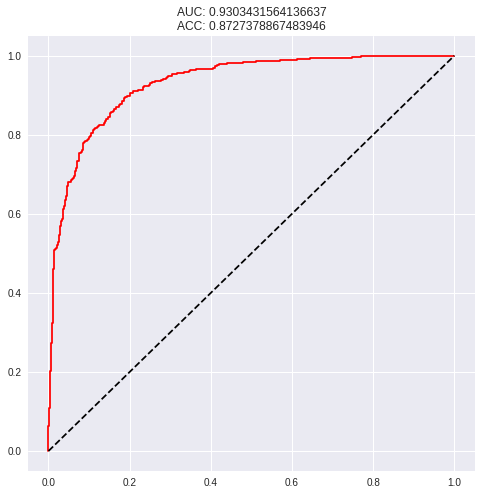

In [194]:
plot_metrics(preds, y_test);